<a href="https://colab.research.google.com/github/sureshmecad/CloudyML-AI-FOR-ALL/blob/main/Clustering_CloudyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><u>Clustering</u></center>

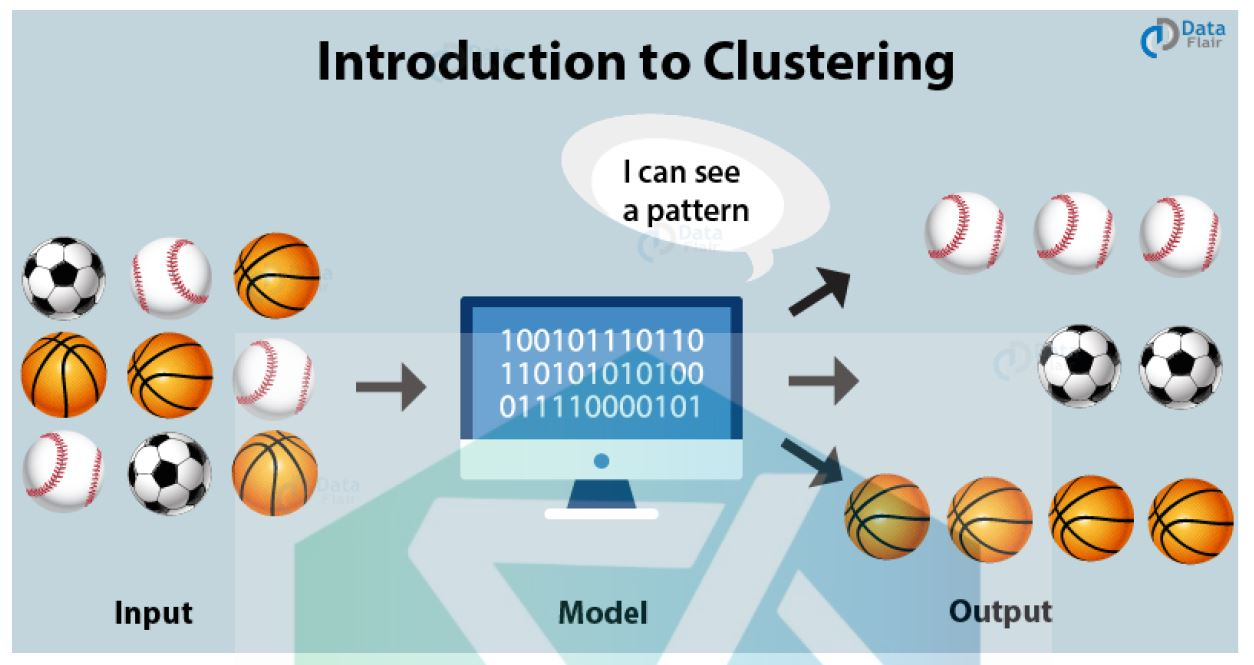

Clustering is the task of dividing the population or data points into a number of groups such that data points in the same groups are more similar to other data points in the same group and dissimilar to the data points in other groups. It is basically a collection of objects on the basis of similarity and dissimilarity between them.


Clustering is very much important as it determines the intrinsic grouping among the unlabeled data present. There are no criteria for a good clustering. It depends on the user, what is the criteria they may use which satisfy their need

Clustering techniques apply when there is no class to be predicted but rather when the instances are to be divided into natural groups.

We will learn various Clustering methods in this assignment, like:

1. Agglomerative Hierarchical Clustering
2. BIRCH
3. DBSCAN
4. K-Means
5. Mini-Batch K-Means
6. Mean Shift
7. OPTICS
8. Spectral Clustering
9. Gaussian Mixture Model

So be excited to rock this assignment! :)

We are providing you one intro video on gist of unsupervised learning: https://youtu.be/KWdC01NUFkM


**Problem Statement :**

Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

*Note : The dataset is provided in your Canvas Account

We will be using the online reatil transactional dataset to build a RFM (R(Recency), F(Frequency), M(Monetary)) clustering and choose the best set of customers.

### Importing Basic Library

In [14]:
# import important library'

#Importing Libraries
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale


## Data preparation

<p style='text-align: right;'> 10 points</p>


### Reading the Data Set

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# reading Dataset: specify sepearted by comma, encoded by ISO-8859-1 and header is 0
retail = pd.read_csv("/content/drive/MyDrive/CloudyML/Online Retail.zip", sep=',', encoding='ISO-8859-1', header=0)

# print retil head
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [17]:
# parse date into a format like "d-m-Y H:M"
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format= "%d-%m-%Y %H:%M")

#### Sanity Check


In [18]:
# print dataset shape
print(retail.shape)

# print description of dataset 
print(retail.describe())

# Print basic datatype info on dataset
print(retail.dtypes)

(541909, 8)
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


##### Null value Handling


In [19]:
# print percentage of null values in each column
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [20]:
# dropping the na cells from retail data
order_wise = retail.dropna()

In [21]:
# Sanity check for null values
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### RFM implementation

Extracting R(Recency), F(Frequency), M(Monetary) columns form the above data



In [22]:
# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns=['Amount'])

# merging amount in order_wise keeping  ignore_index = False
order_wise = pd.concat(objs = [order_wise, amount], axis=1, ignore_index=False)

# print head of amount 
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


#### Monetary Value

In [24]:
# Finding total amount spent per customer
monetary = order_wise.groupby("CustomerID").Amount.sum()

# reset index of monetory 
monetary = monetary.reset_index()

# print monetary head
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Note: If in the above result you get a column with name level_1, run the below code , else ignore it and keep moving.

`monetary.drop(['level_1'], axis = 1, inplace = True)
monetary.head()`

#### Frequency Value

In [25]:
#Extract Frequency function by reading just 'CustomerID' and 'InvoiceNo' form order_wise
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [26]:
# Getting the count of orders made by each customer based on customer ID in frequency dataframe
k = frequency.groupby('CustomerID').InvoiceNo.count()

# save k in a dataframe
k = pd.DataFrame(k)

# reset index of k
k = k.reset_index()

# name columns of k as "CustomerID" and "Frequency"
k.columns = ['CustomerID', 'Frequency']

# print head of k
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


##### creating master dataset



In [27]:
# Merging monetary and Frequency on CustomerID doing the inner join
master = monetary.merge(k, on='CustomerID', how='inner')

# print head of master
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Recency Value

Generating recency function


In [28]:
# Filtering order_wise data for customerid and invoice_date
recency  = order_wise[['CustomerID', 'InvoiceDate']]

# Finding maximum InvoiceDate

maximum = max(recency.InvoiceDate)

# Adding one more day to the above data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)

# Find difference between maximum date and Invoice date in regency, save it in column name diff
recency['diff'] = maximum - recency.InvoiceDate

# print regency head
recency.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [29]:
# group recency by customerid and get minimum value of corresponding diff column
df = pd.DataFrame(recency.groupby("CustomerID")['diff'].min())

# reset index of df
df = df.reset_index()

# name columns of df as "CustomerID" and "Recency"
df.columns = ["CustomerID", "Recency"]

# print head of df
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


### RFM combined DataFrame

Combining all recency, frequency and monetary parameters


In [30]:
# Merge master with df on CustomerID
RFM = master.merge(df, on='CustomerID')

# Print head of RFM
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


### Outlier Treatment

1. outlier treatment for Amount


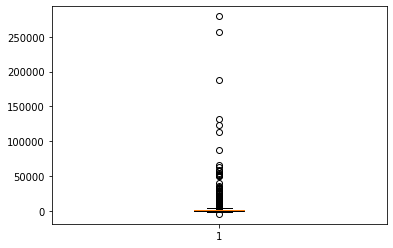

In [31]:
# box plot amount column from RFM
plt.boxplot(RFM.Amount)

# get 25% quantile range of amount
Q1 = RFM.Amount.quantile(0.25)

# get 75% quantile range of amount
Q3 = RFM.Amount.quantile(0.75)

# GEt difference between first and third quantile
IQR = Q3-Q1

# Remove outliers by filtering amount more than or equal to Q1-1.5*IQR and less than  or equal to Q3 + 1.5*IQR
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

2. outlier treatment for Frequency


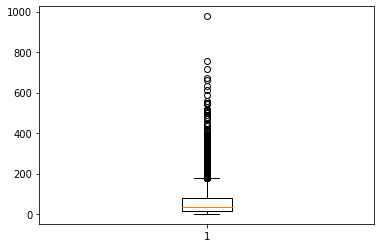

In [32]:
# box plot Frequency column from RFM
plt.boxplot(RFM.Frequency)

# get 25% quantile range of Frequency
Q1 = RFM.Frequency.quantile(0.25)

# get 75% quantile range of Frequency
Q3 = RFM.Frequency.quantile(0.75)

# GEt difference between first and third quantile
IQR = Q3-Q1

# Remove outliers by filtering Frequency more than or equal to Q1-1.5*IQR and less than  or equal to Q3 + 1.5*IQR
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

3.  outlier treatment for Recency


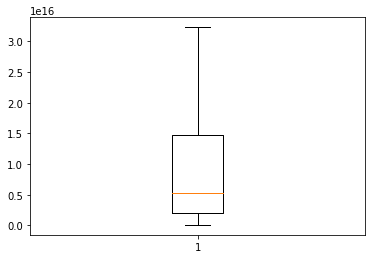

In [33]:
# box plot Recency column from RFM
plt.boxplot(RFM.Recency)

# get 25% quantile range of Recency
Q1 = RFM.Recency.quantile(0.25)

# get 75% quantile range of Recency
Q3 = RFM.Recency.quantile(0.75)

# GEt difference between first and third quantile
IQR = Q3-Q1

# Remove outliers by filtering Recency more than or equal to Q1-1.5*IQR and less than  or equal to Q3 + 1.5*IQR
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [34]:
# Drop 'CustomerID' from RFM column
RFM_norm1 = RFM.drop("CustomerID", axis=1)

# Extract days from column Recency and update your Recency column
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

In [35]:
# print head of RFM_norm1
RFM_norm1.head()

,Amount,Frequency,Recency
0,0.00,2,326
2,1797.24,31,75
3,1757.55,73,19
4,334.40,17,310
5,1545.41,95,36


### Scaling the RFM data

In [38]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler

# standardise all parameters
standard_scaler = StandardScaler()

# fit_transform your RFM_norm1
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [39]:
# save RFM_norm1 into a DataFrame
RFM_norm1 = pd.DataFrame(RFM_norm1)

# Change columns names as  ['Frequency','Amount','Recency']
RFM_norm1.columns = ['Frequency','Amount','Recency']

# print head of RFM_norm1
RFM_norm1.head()

,Frequency,Amount,Recency
0,-1.041614,-1.070949,2.136422
1,1.385298,-0.375498,-0.282050
2,1.331702,0.631707,-0.821629
3,-0.590055,-0.711233,1.982257
4,1.045238,1.159290,-0.657828


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

Some usefull links to understand Hopkins Statistics:
- [Video](https://www.youtube.com/watch?v=50v6Lrl8gw4)
- [Article](https://sushildeore99.medium.com/really-what-is-hopkins-statistic-bad1265df4b)

We are providing you the below function to calculate Hopkins score.

In [40]:
# Function to calculate Hopkins score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [41]:
# Use hopkins() function on RFM_norm1 
hopkins(RFM_norm1)

0.8925320523418299

If we use 0.5 as the threshold to reject the alternative hypothesis. That is, if H < 0.5, then it is unlikely that Data has statistically significant clusters.

Put in other words, If the value of Hopkins statistic is close to 1, then we can reject the null hypothesis and conclude that the dataset D is significantly a clusterable data. So here we can see possibility of clustering.

## K-Means with some K

<p style='text-align: right;'> 10 points</p>


Reference video: https://www.youtube.com/watch?v=AWKCCK5YHsE

Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

The K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

In [42]:
# To perform KMeans clustering 
from sklearn.cluster import KMeans

# Kmeans with K=5, max_iter as 50 and random_state as 1
model_clus5 = KMeans(n_clusters=5, max_iter=50, random_state=1)

# Fit Kmeans on RFM_norm1
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5, random_state=1)

## Optimal K Value

Finding the optimal number of clusters is an important part of this algorithm. Commonly used method for finding optimal K value is 
1. Silhouette Analysis
2. Elbow Method.  

### Silhouette Analysis

Reference doc: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Reference video: https://www.youtube.com/watch?v=DpRPd274-0E

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [43]:
# import silhouette_score
from sklearn.metrics import silhouette_score

# Initialise empty array to append result
sse_ = []

# Iterate over different k values (here 2 to 15)
for k in range(2, 15):
    
#     fit KMeans on different k values with max_iter=50, random_state=1
    kmeans = KMeans(n_clusters=k, max_iter=50, random_state=1).fit(RFM_norm1)
    
    # append silhouette_score for every k value keeping parameters as RFM_norm1 and  kmeans.labels_
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

###### Visualise silhouette_score vs Number of Clusters

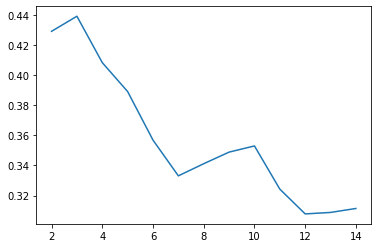

In [45]:
# Plot K vs silhouette_score
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

Above plot shows best silhouette_score on cluster number 3. Lets check another visualisation tool to confirm if k=3 is optimal 

We will use yellowbrick library for this

Reference link: https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

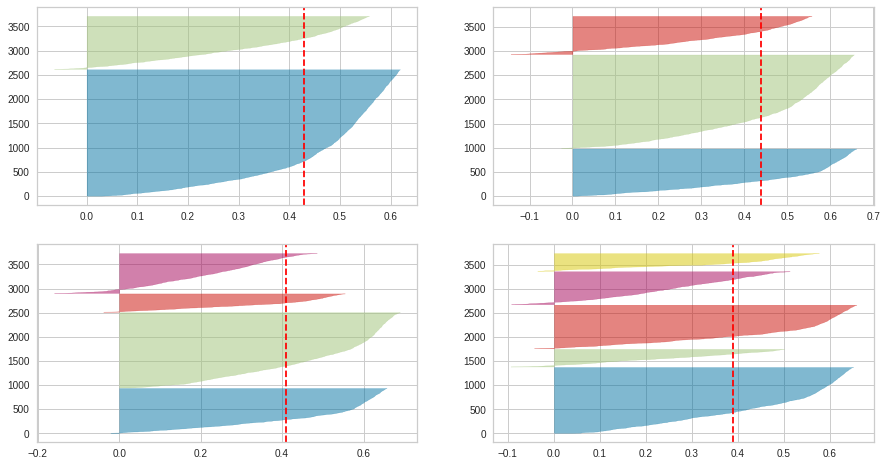

In [46]:
# import yellowbrick 
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))

# iterate from range 2 to 5
for i in [ 2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters with n_init as 10, max_iteration as 50 and random_state as 1
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=50, random_state=1)
    
    
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance with ax as ax[q-1][mod] and colors as yellowbrick
    
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    
#     Fit the visualizer 
    visualizer.fit(RFM_norm1)

Now question comes, how to analyse optimal k value from above plots. 

The value of n_clusters as 4 and 5 looks to be suboptimal for the given data due to the following reasons:
- Presence of clusters with below-average silhouette scores 
- Wide fluctuations in the size of the silhouette plots.
- The value of 2 and 3 for n_clusters looks to be the optimal one. The silhouette score for each cluster is above average silhouette scores. Also, the fluctuation in size is similar. The thickness of the silhouette plot representing each cluster also is a deciding point. For the plot with n_cluster 3 (top right), the thickness is more uniform than the plot with n_cluster as 2 (top left) with one cluster thickness much more than the other. 

Thus, one can select the optimal number of clusters as 3.

## Sum of Squared Distances/ Elbow Method

Reference link: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Reference video: https://youtu.be/06824vgudgM

This is probably the most well-known method for determining the optimal number of clusters. It is also a bit naive in its approach.
Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.

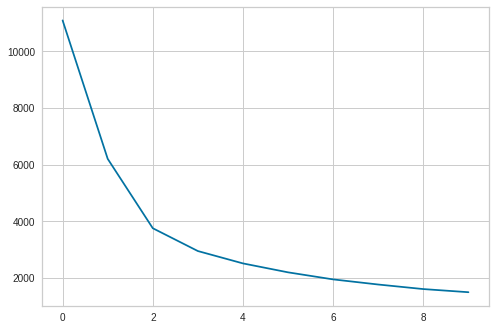

In [47]:
# Initialise empty array to store score
ssd = []

# Iterate for different k values ( from 1 to 21)
for num_clusters in list(range(1,11)):
    
    # Instantiate K means for different k values and max_iter as 50 and random state as 42
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50, random_state=42)
    
    # fit above model with RFM_norm1
    model_clus.fit(RFM_norm1)
    
    # calculate sum of squared distances and append in ssd (Use: inertia_ on model_clus)
    ssd.append(model_clus.inertia_)

# plot ssd
plt.plot(ssd)
plt.show()

Lets also use yellowbrick for deciding k visualy

Reference link: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

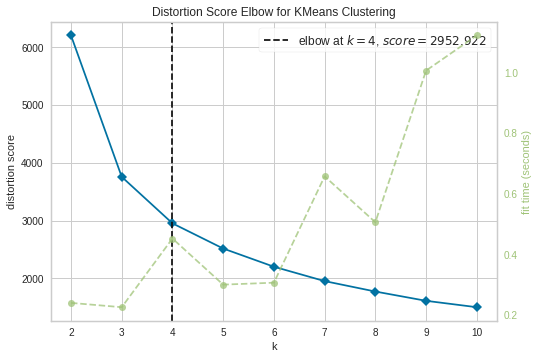

AttributeError: ignored

TypeError: ignored

In [49]:
# import kelbow_visualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# kelbow_visualizer with Kmeans which has parameters random_state=42, max_iter=50, and k range from 1 to 11
kelbow_visualizer(KMeans(random_state=42, max_iter=50), RFM_norm1, K=(1,11))

the above elbow is clear at k = 3. However, this choice is ambiguous as we could choose k to be either 2 or 3.
In such an ambiguous case, we may use the Silhouette Method.

### Analysis of clusters formed


In [50]:
# Set index of RFM in the range of length of RFM.index
RFM.index = pd.RangeIndex(len(RFM.index))

# create a series of lable in model_clus5
m = pd.Series(model_clus5.labels_)

# Concat RFM and m  columnwise
RFM_km = pd.concat([RFM, m], axis=1)

# name columns as ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

# Covert values in Recency into days only
RFM_km.Recency = RFM_km.Recency.dt.days

# Create a dataframe of mean amount for each group of ClusterID
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())

# Create a dataframe of mean Frequency for each group of ClusterID
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())

# Create a dataframe of mean Recency for each group of ClusterID
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [51]:
# concat series of [0,1,2,3,4] with km_clusters_amount, km_clusters_frequency and km_clusters_recency columnwise
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency])

# name columns as ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]

# print df
df

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0.0,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN
3,3.0,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN
0,NaN,23.325785,NaN,NaN
1,NaN,114.021798,NaN,NaN
2,NaN,20.558856,NaN,NaN
3,NaN,53.668613,NaN,NaN
4,NaN,117.888283,NaN,NaN


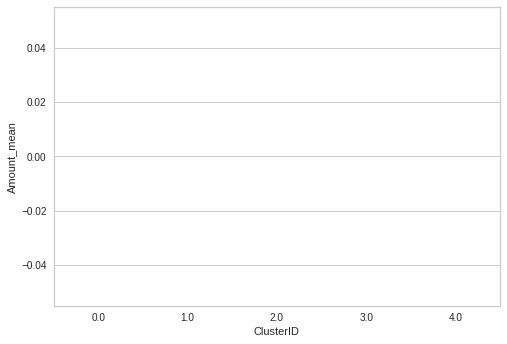

In [52]:
# barplot for each ClusterID w.r.t mean amount
sns.barplot(x=df.ClusterID, y=df.Amount_mean)
plt.show()

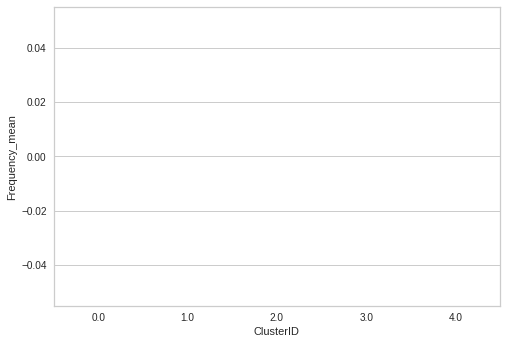

In [53]:
# barplot for each ClusterID w.r.t mean Frequency
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)
plt.show()

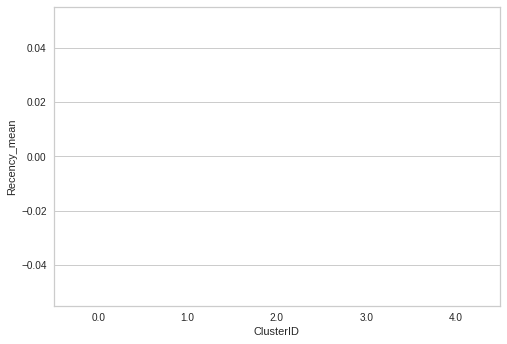

In [54]:
# barplot for each ClusterID w.r.t mean Recency
sns.barplot(x=df.ClusterID, y=df.Recency_mean)
plt.show()

Well done. You have suuccessfully implemented Kmeans clustering technique. From the the above bar plot we analysed that maximum mean Recency is at k =3 but maximum mean Frequency and amount at k=2

<hr>

## Heirarchical Clustering

<p style='text-align: right;'> 10 points</p>



Reference video: https://youtu.be/5_d9-fAswM0

https://youtu.be/OO6tfKnFzrE


Like K-means clustering, hierarchical clustering also groups together the data points with similar characteristics. In some cases the result of hierarchical and K-Means clustering can be similar. Before implementing hierarchical clustering using Scikit-Learn, let's first understand the theory behind hierarchical clustering.

There are two types of hierarchical clustering: 

`1. Agglomerative : data points are clustered using a bottom-up approach starting with individual data points
2. Divisive.:  while in this top-down approach is followed where all the data points are treated as one big cluster and the clustering process involves dividing the one big cluster into several small clusters.`

Heirarchical clustering methods predict subgroups within data by:

1) Finding distance between each data points and its nearest neighbors
2) Linking the most nearby neighbors

Lets first look at the dendograms. What!!! but wait what is dendograms now? 

You can find the number of subgroups that are appropriate for a heirarchical clustering model by looking at dendograms. 
A dendrogram is a diagram representing a tree for visually displaying taxonomies, lineages and relatedness.

Reference video: https://www.youtube.com/watch?v=JcfIeaGzF8A

Reference doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

### Scipy Dendograms

Lets first try using linkage with different methods and check clusters visually. 

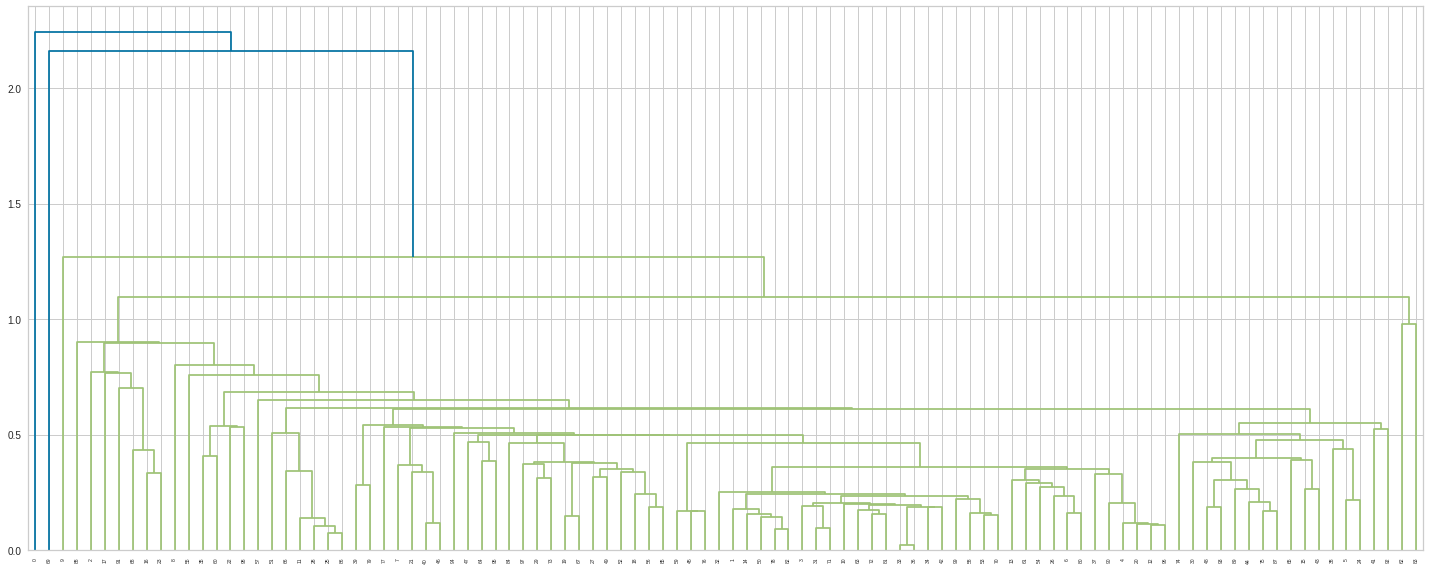

In [58]:
# import dendrogram and linkage from scipy
from scipy.cluster.hierarchy import dendrogram, linkage

# Get random 100 sample from RFM_norm1 with random_state=10 ( to reduce computation time)
RFM_Sample = RFM_norm1.sample(100, random_state=10)

# Check linkage on RFM_Sample  with  method as single and distance metrix as euclidean
mergings = linkage(RFM_Sample, method='single', metric="euclidean")

# Use dendrogram to plot above mergings with figsize=(25, 10)
fig = plt.figure(figsize=(25, 10))
dendrogram(mergings)
plt.show()

In above plot also if we take maximum distance between clusters to be 1.2, then we can see that we get 3 subgroups/ clusters

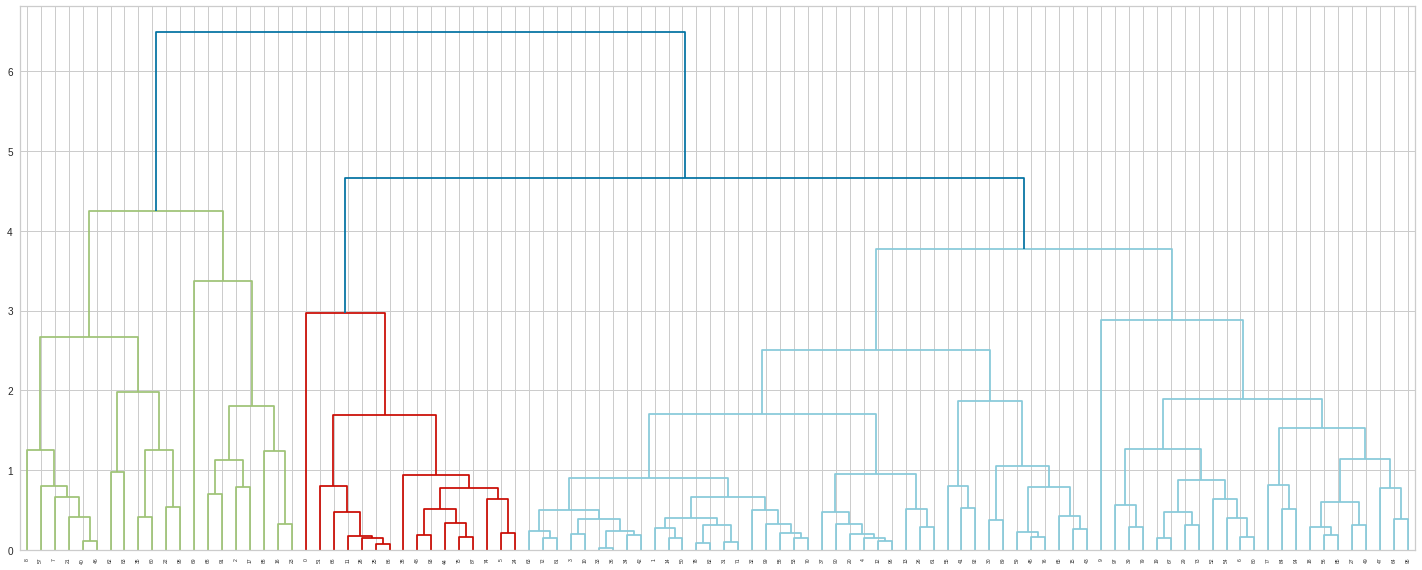

In [59]:
# Check linkage on RFM_Sample  with  method as complete and distance metrix as euclidean
mergings = linkage(RFM_Sample, method='complete', metric="euclidean")

# Use dendrogram to plot above mergings with figsize=(25, 10)
fig = plt.figure(figsize=(25, 10))
dendrogram(mergings)
plt.show()

In above diagram, if we take maximum distance to be 4 then we get 3 subgroups or clusters here . But if we take 5 as maximum distance then we get 2 clusters. Lets decide a threshold of 4 and cut the dendrogram:


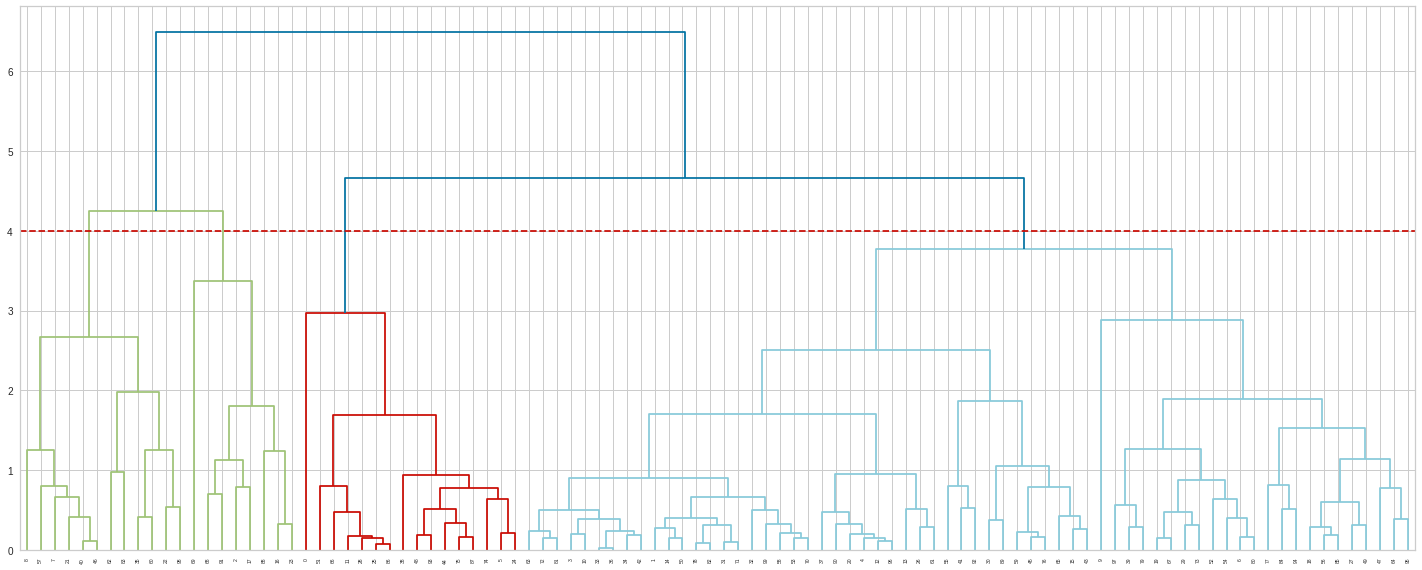

In [60]:
# Use dendrogram to plot mergings with figsize=(25, 10) also plotting vertical line at 4 to cut dendogram
fig = plt.figure(figsize=(25, 10))
dendrogram(mergings)
plt.axhline(y=4, color='r', linestyle='--')
plt.show()

We have three clusters as this line cuts the dendrogram at three points. Let’s now apply hierarchical clustering for 3
clusters:



### Agglomerative Clustering
Now lets Generate our no. of clusters using Agglomerative Clustering method

Reference doc:  https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html 



In [61]:
# import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# Define number of clusters (here 3)
k = 3

# Instantiate AgglomerativeClustering with n_clusters as k, affinity as euclidean and linkage as ward
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')

# fit RFM_norm1 in above model
clus = cluster.fit_predict(RFM_norm1)

Can refer below doc for scatter plot clusters: https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318

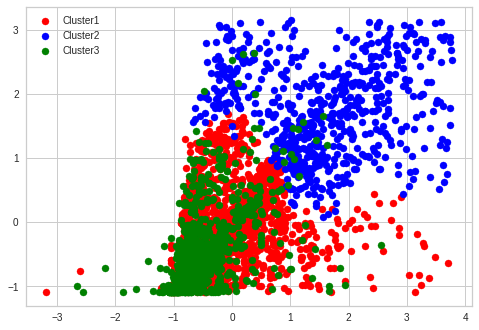

In [62]:
# convert RFM_norm1 in to numpy array
RFM_norm2 = np.array(RFM_norm1)

# Scatter plot all clusters formed 
plt.scatter(RFM_norm2[clus==0, 0], RFM_norm2[clus==0, 1], s=50, marker='o', color='red', label='Cluster1')
plt.scatter(RFM_norm2[clus==1, 0], RFM_norm2[clus==1, 1], s=50, marker='o', color='blue', label='Cluster2')
plt.scatter(RFM_norm2[clus==2, 0], RFM_norm2[clus==2, 1], s=50, marker='o', color='green', label='Cluster3')
plt.legend()
plt.show()

In [63]:
# import metrics
from sklearn import metrics

# Lets check silhouette_score on this model
print(metrics.silhouette_score(RFM_norm1, clus))

0.4014568318292945


## BIRCH

<p style='text-align: right;'> 10 points</p>


Reference doc : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html

Reference article: https://thecleverprogrammer.com/2021/03/15/birch-clustering-in-machine-learning/

Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH) is a clustering algorithm in machine learning that has been specially designed for clustering on a very large data set. It is often faster than other clustering algorithms like batch K-Means. It provides a very similar result to the batch K-Means algorithm if the number of features in the dataset is not more than 20.

When training the model using the BIRCH algorithm, it creates a tree structure with enough data to quickly assign each data point to a cluster. By storing all the data points in the tree, this algorithm allows the use of limited memory while working on a very large data set

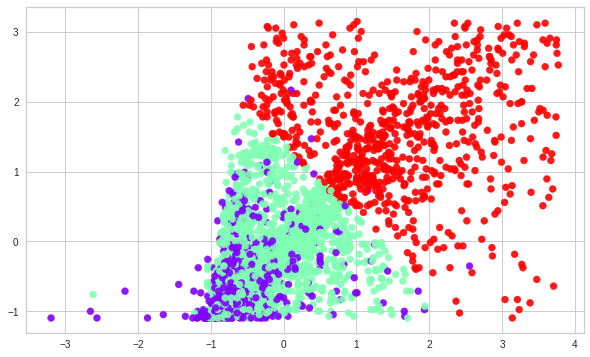

In [66]:
# let’s import the BIRCH class from the sklearn library
from sklearn.cluster import Birch

# Instantiate Birch with branching_factor as 30 and thresholda as 1.5 and n_clusters as None.
model = Birch(branching_factor=30, n_clusters=None, threshold=1.5)

# fit model on RFM_norm1 
model.fit(RFM_norm1)

# predict model on RFM_norm1 only
pred = model.predict(RFM_norm1)

# Scatter plot keeping x and y as first 2 parameters of RFM_norm1 and c as pred,cmap as rainbow, alpha as 0.5 and edgecolor as black
fig = plt.figure(figsize=(10, 6))
plt.scatter(RFM_norm1["Frequency"], RFM_norm1["Amount"], c=pred, cmap='rainbow', alpha=0.9)
plt.show()

Hey did you see that the above plot looks alike to the Agglomerative scatter plot. We were lucky to have proper parameters for birch model, but if you change threshold value or number of clusters, then your scatter plot won't look the same. You can try changing it and see the results if you want

In [67]:
# Lets check silhouette_score on this model
print(metrics.silhouette_score(RFM_norm1, model.labels_))

0.4394534595347018


## DBSCAN

<p style='text-align: right;'> 10 points</p>


Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
        
Reference video: https://www.youtube.com/watch?v=1RDyVAoFKgY
 
 or https://www.youtube.com/watch?v=C3r7tGRe2eI
        
Density Based Spatial Clustering of Applications with Noise(DBCSAN) is a clustering algorithm. It can be used for clustering data points based on density, i.e., by grouping together areas with many samples. This makes it especially useful for performing clustering under noisy conditions: as we shall see, besides clustering, DBSCAN is also capable of detecting noisy points, which can – if desired – be discarded from the dataset.
        

In [68]:
# import DBSCAN library from sklearn
from sklearn.cluster import DBSCAN

# Keep epsilon as 1
epsilon = 1

# Keep min_samples as 13
min_samples = 13

# Compute  and fit DBSCAN with above epsilon and min_samples
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(RFM_norm1)

In [69]:
# Get lables from db using labels_
labels = db.labels_

# check length of unique labels
no_clusters = len(np.unique(labels))

# check total of labels  equals to 1 along the rows to know noice in the data
no_noise = np.sum(np.array(labels) ==-1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 12


Hint: please watch reference video to get idea to implement below code


In [70]:
# Getting numpy array of noice ( use zeros_like with labels and dtype as bool) 
sample_cores = np.zeros_like(labels, dtype=bool)

# Get values in sample_cores which are other than noice using condition db.core_sample_indices_=True
sample_cores[db.core_sample_indices_]=True

# Get number of clusters by subtracting length of labels with noice
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# print n_clusters
n_clusters

1

Lets find silhouette_scores on DBSCAN result

Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [71]:
# calculate and print silhouette_score 
print(metrics.silhouette_score(RFM_norm1, labels))

0.43048292908608643


The best value is 1 and the worst value is -1 in silhouette_score. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

We got an average result out of DBSCAN which is a similar case in K means clustering.

## Mini-Batch K-Means clustering

<p style='text-align: right;'> 10 points</p>


reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

K-Means algorithmIt is a commonly used clustering algorithm, but its algorithm itself has certain problems. For example, the long calculation time under a large amount of data is an important problem. For this reason, Mini Batch K-Means, this variant clustering algorithm based on K-Means came into being

Mini Batch K-means algorithm‘s main idea is to use small random batches of data of a fixed size, so they can be stored in memory. Each iteration a new random sample from the dataset is obtained and used to update the clusters and this is repeated until convergence.




To know difference between mbkmeans and kmeans, check this doc: https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html


In [72]:
# import MiniBatchKMeans and pairwise_distances_argmin
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

# perform the mini batch K-means with number of clusters as 3 and random state as 1
mbk = MiniBatchKMeans(n_clusters=3, random_state=1)
  
# fit model on RFM_norm1
mbk.fit(RFM_norm1)

# sort cluster_centers for each rows 
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)

# get pairwise_distances_argmin with RFM_norm1 and mbk_means_cluster_centers
mbk_means_labels = pairwise_distances_argmin(RFM_norm1, mbk_means_cluster_centers)
  
# print the labels of each data
print(mbk_means_labels)

# lets check silhouette_score using mbk_means_labels
print(metrics.silhouette_score(RFM_norm1, mbk_means_labels))

[0 1 1 ... 0 0 1]
0.14051342777954287


In [73]:
# predict mbk on RFM_norm2
yhat = mbk.predict(RFM_norm2)

# retrieve unique clusters from yhat
clusters = np.unique(yhat)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MiniBatchKMeans was fitted with feature names
  "X does not have valid feature names, but"


Create scatter plot for samples from each cluster


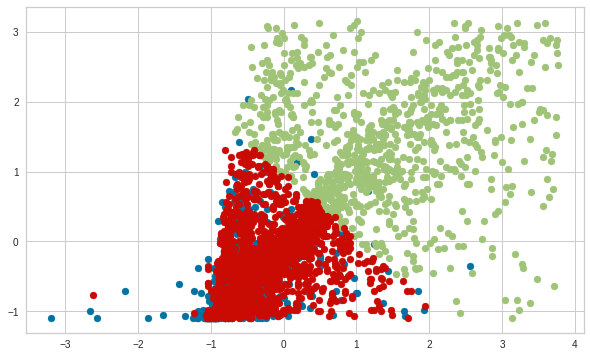

In [74]:
fig = plt.figure(figsize=(10, 6))

# iterate over clusters
for cluster in clusters:
    # get row indexes for samples with this cluster (Hint: where condition with yhat==cluster)
    row_ix = np.where(yhat == cluster)

    # create scatter of these samples (hint: Use RFM_norm2[row_ix, 0], RFM_norm2[row_ix, 1] )
    plt.scatter(RFM_norm2[row_ix, 0], RFM_norm2[row_ix, 1])

# show the plot
plt.show()

The above plot looks similar to the plot in Birch method. Well but the silhouette_score is lesser in this case compared to k means, birch and dbscan

## Mean Shift Clustering Method

<p style='text-align: right;'> 10 points</p>


Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
    
Reference video: https://www.youtube.com/watch?v=dRVO6GIMAhc

        
Mean Shift clustering algorithm is an unsupervised clustering algorithm that groups data directly without being trained on labelled data. The nature of the Mean Shift clustering algorithm is heirarchical in nature, which means it builds on a heirarchy of clusters, step by step.

As opposed to K-Means, when using Mean Shift, you don’t need to know the number of categories (clusters) beforehand. The downside to Mean Shift is that it is computationally expensive — O(n²).

In [75]:
# import MeanShift
from sklearn.cluster import MeanShift

# Instantiate Meanshift 
ms = MeanShift()

# fit above model with RFM_norm2
ms.fit(RFM_norm2)

# Get cluster centers using cluster_centers_
cluster_centers = ms.cluster_centers_

# print unique labels obtained
print(np.unique(ms.labels_))

[0]


Hey did you notice in above result, we got only 1 cluster using MeanShift method

You can read how it works :

Given a set of data points, the algorithm iteratively assigns each data point towards the closest cluster centroid and direction to the closest cluster centroid is determined by where most of the points nearby are at. So each iteration each data point will move closer to where the most points are at, which is or will lead to the cluster center. When the algorithm stops, each point is assigned to a cluster.

So according to MeanShift in our case each data point has a common centroid, hence we got only one label

## OPTICS

<p style='text-align: right;'> 10 points</p>


Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

Reference video: https://www.youtube.com/watch?v=9Zy-JfgAHRc

OPTICS Clustering stands for Ordering Points To Identify Cluster Structure. It draws inspiration from the DBSCAN clustering algorithm. This is a density based clustering method.

Density based clusering locates regions of high density that are seperated from one another by regions of low density

Density =number of points within a specified radius (Eps)

Technically speaking, OPTICS isn’t actually a clustering algorithm. Instead, it creates an ordering of the cases in the data in such a way that we can extract clusters from it. That sounds a little abstract, isn't it.


Please do refer above reference links to know depth of OPTICS and its working.

In [76]:
# import OPTICS
from sklearn.cluster import OPTICS

# Instialise and fit Optics on RFM_norm2
Ops = OPTICS().fit(RFM_norm2)

# Get labels obtained
labels = Ops.labels_

In [77]:
# check length of unique labels
no_clusters = len(np.unique(labels))

#check total of labels  equals to -1 along the rows to know noice in the data
no_noise = np.sum(np.array(labels) ==-1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 136
Estimated no. of noise points: 2644


Omg! you have got so many distinct clusters here


Let's change parameters in OPTICS and run again keeping 
- epsilon = 2.0
- min_samples = 30

In [78]:
# Initialising Optics with above modified parameters
Ops = OPTICS(eps=2, min_samples=30).fit(RFM_norm2)

# Get labels obtained
labels = Ops.labels_

# check length of unique labels
no_clusters = len(np.unique(labels))

#check total of labels  equals to -1 along the rows to know noice in the data
no_noise = np.sum(np.array(labels) ==-1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 2
Estimated no. of noise points: 3649


Now if we see we got 2 clusters, but since one of the two cluster represents noice, so we have only 1 relevant cluster

We can also easily generate the reachability plot:



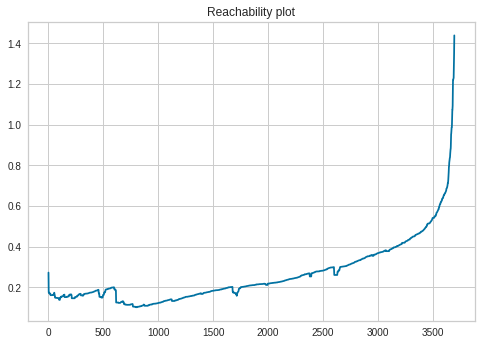

In [80]:
# Use Ops.reachability_[Ops.ordering_] to know the reachability
reachability = Ops.reachability_[Ops.ordering_]

# plot reachability_
plt.plot(reachability)
plt.title("Reachability plot")
plt.show()

From above reachability plot we can see  only 2 valleys, one small and one big

We saw that OPTICS works by ordering based on reachability distance while expanding the clusters at the same time. The output of the OPTICS algorithm is therefore an ordered list of reachability distances, which by means of thresholds or different techniques we can split into clusters. This way, we’re able of generating clusters for groups of data that have varying densities.

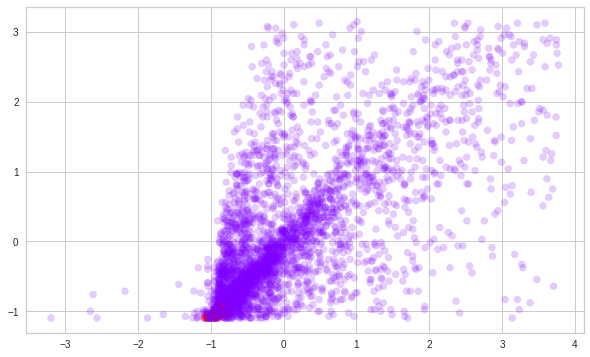

In [81]:
pred = Ops.fit_predict(RFM_norm2)
# print(ClusterData.head())
 
fig = plt.figure(figsize=(10, 6))

# Plotting the predicted clusters using any 2 columns in RFM_norm1 and keeping c as pred and cmap as rainbow and alpha as 0.2
plt.scatter(RFM_norm1["Frequency"], RFM_norm1["Amount"], c=pred, cmap='rainbow', alpha=0.2)
plt.show()

From above plot you can see that small red portion is the only recognised cluster in he dataset as per OPTICS. 

Lets check total count of each unique labels

In [82]:
# Get unique value and counts in the label 
unique, counts = np.unique(labels, return_counts=True)

# Save and print unique value and their total counts in s dictionary
dict(zip(unique, counts))

{-1: 3649, 0: 48}

here you can see large number of points are noice and same is represented in the bove plot as well.

In [83]:
# Lets check silhouette_score on OPTICS
print(metrics.silhouette_score(RFM_norm1, labels))

0.2536780059197283


The silhouette_score here better than Mean Shift, but still Kmeans has better score so far.

## Spectral Clustering

<p style='text-align: right;'> 10 points</p>



Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

Reference video: 

spectral clustering has become one of the most popular modern clustering algorithms. It is simple to implement, can be solved efficiently by standard linear algebra software, and very often outperforms traditional clustering algorithms such as the k-means algorithm.

“Spectral clustering is one of the most popular forms of multivariate statistical analysis” ‘Spectral Clustering uses the connectivity approach to clustering’, wherein communities of nodes (i.e. data points) that are connected or immediately next to each other are identified in a graph. 
The nodes are then mapped to a low-dimensional space that can be easily segregated to form clusters. Spectral Clustering uses information from the eigenvalues (spectrum) of special matrices (i.e. Affinity Matrix, Degree Matrix and Laplacian Matrix) derived from the graph or the data set.

When compared with other algorithms, it is computationally fast for sparse datasets of several thousand data points. You don’t need the actual dataset to work with. Distance or Though it might be costly to compute for large datasets as eigenvalues and eigenvectors need to be computed and then clustering is to be done. But the algorithms try to cut the cost. The number of clusters (k) needs to be fixed before starting the procedure.

In [84]:
# import Spectral Clustering
from sklearn.cluster import SpectralClustering

# Instantiate SpectralClustering with number of clusters as 4 and fit the same with RFM_norm2
sc = SpectralClustering(n_clusters=4).fit(RFM_norm2)

# print dustinct unique values
print(np.unique(sc.labels_))

[0 1 2 3]


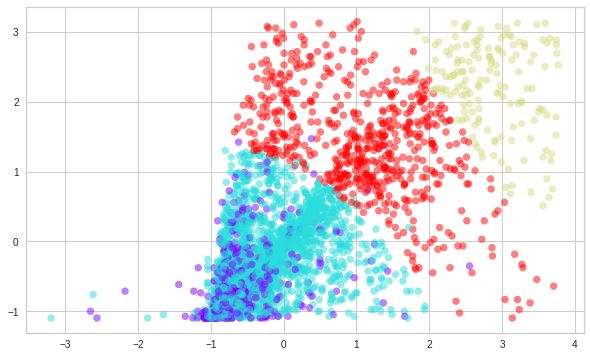

In [85]:
# fit_predict above model on RFM_norm2
pred = sc.fit_predict(RFM_norm2)
 
fig = plt.figure(figsize=(10, 6))

# Plotting the predicted clusters keeping x and y as RFM_norm1["Frequency"] and RFM_norm1["Amount"] and c as pred
plt.scatter(RFM_norm1["Frequency"], RFM_norm1["Amount"], c=pred, cmap='rainbow', alpha=0.5)
plt.show()

Lets use kelbow_visualizer to get optimal value of k in SpectralClustering

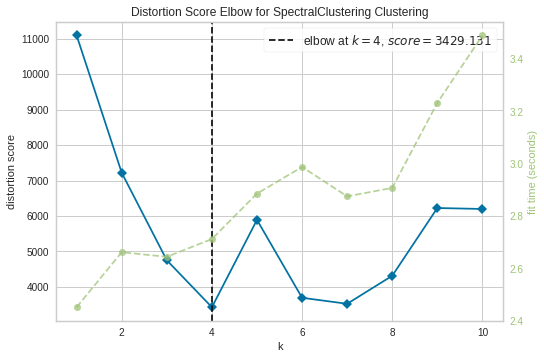

In [86]:
# kelbow_visualizer with Kmeans which has parameters random_state=42 and k range from 1 to 11
kelbow_visualizer(SpectralClustering(random_state=42), RFM_norm1, k=(1,11))
plt.show()

In [87]:
# import silhouette_score and silhouette_samples
from sklearn.metrics import silhouette_score, silhouette_samples

# iterate over different number of clusters ranging from 2 to 11
for n_clusters in range(2,11):

#     Initialise SpectralClustering with n_clusters as n_clusters
    sc = SpectralClustering(n_clusters=n_clusters)

    # fit predict above model on RFM_norm2
    preds = sc.fit_predict(RFM_norm2)

#  Get silhouette_score on above prediction w.r.t RFM_norm2 and metric as euclidean
    score = silhouette_score(RFM_norm2, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4707386039783242
For n_clusters = 3, silhouette score is 0.38640761664222434
For n_clusters = 4, silhouette score is 0.4024904755023276
For n_clusters = 5, silhouette score is 0.37407897377149274
For n_clusters = 6, silhouette score is 0.3648986781283518
For n_clusters = 7, silhouette score is 0.3665666126514499
For n_clusters = 8, silhouette score is 0.29435063059865274
For n_clusters = 9, silhouette score is 0.333021870542784
For n_clusters = 10, silhouette score is 0.2189189000709759


So from above three results i.e 

- Scatter plot
- elbow plot
- silhouette score

We can conclude that according to SpectralClustering method the best k values or total optimal clusters are 4

## Gaussian Mixture Model

<p style='text-align: right;'> 10 points</p>


Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

Reference video: https://youtu.be/051v1EE0Hv0

Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

k-means only considers the mean to update the centroid while GMM takes into account the mean as well as the variance of the data


Lets implement GMM now : refer https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/ help in code



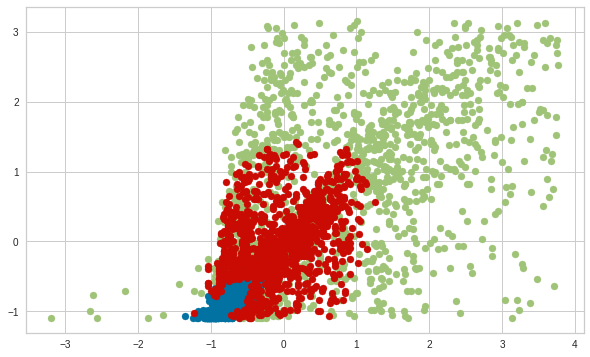

In [88]:
# import GaussianMixture from sklearn
from sklearn.mixture import GaussianMixture

# Instantiate GaussianMixture with random_state as 0, n_components as 3 and fit it on RFM_norm2
gm = GaussianMixture(random_state=0, n_components=3).fit(RFM_norm2)

# predictions from gmm
yhat = gm.predict(RFM_norm2)

# get unique predicted result as clusters
clusters = np.unique(yhat)

fig = plt.figure(figsize=(10, 6))

# iterate over clusters
for cluster in clusters:
    # get row indexes for samples with this cluster (Hint: where condition with yhat==cluster)
    row_ix = np.where(yhat == cluster)

    # create scatter of these samples (hint: Use RFM_norm2[row_ix, 0], RFM_norm2[row_ix, 1] )
    plt.scatter(RFM_norm2[row_ix, 0], RFM_norm2[row_ix, 1])

# show the plot
plt.show()

In [89]:
# Print silhouette_score based on above prediction
silhouette_score(RFM_norm2, yhat)

0.17769622188718867

From above plot you can see that silhouette_score far lesser compared to all other clustering algorithms we have seen till now. 
But no issues, we have total of 9 results out of 9 different clustering algorithms.

Among all the algorithm the optimal clusters with best score is given my BIRCH, K-MEANS and Agglomerative Clustering methods.

Well done buddy! you did a great job :)

---------------------
# Cheers ! Congrats..you have completed your Clustering challenge too!

----------------

# FeedBack Time

We hope you’ve enjoyed this course so far. We’re committed to help you use "AI for All" course to its full potential, so that you have a great learning experience. And that’s why we need your help in form of a feedback here.

Please fill this feedback form https://docs.google.com/forms/d/e/1FAIpQLSfjBmH0yJSSA34IhSVx4h2eDMgOAeG4Dk-yHid__NMTk3Hq5g/viewform
